In [2]:
import numpy as np
import os
import cv2

In [3]:
classes = ['cat', 'cow', 'dog', 'lamb', 'zebra']
data_dir = 'dataset'

In [4]:
X, y = [], []

In [5]:
def load_image_flatten(img_path, size=(128 , 128)):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return None
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray.flatten()

In [6]:
for label, cls in enumerate(classes):
    cls_dir = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_dir):
        continue
    for file in os.listdir(cls_dir):
        path = os.path.join(cls_dir, file)
        features = load_image_flatten(path)
        if features is not None:
            X.append(features)
            y.append(label)

In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
def my_pca_with_scaling(X, k):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std[X_std == 0] = 1
    X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

    cov_mat = np.cov(X_scaled, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_idx]
    eigenvalues = eigenvalues[sorted_idx]

    eigenvectors_k = eigenvectors[:, :k]


    X_reduced = np.dot(X_scaled, eigenvectors_k)

    return X_reduced, eigenvectors_k, eigenvalues[:k]

In [9]:
import matplotlib.pyplot as plt
n_components = min(100, X.shape[0])
X_pca, eigenvectors_k, eigenvalues_k = my_pca_with_scaling(X, n_components)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier(alpha=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f} %")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

Accuracy: 44.34 %

Classification Report:
              precision    recall  f1-score   support

         cat       0.60      0.68      0.64        22
         cow       0.22      0.20      0.21        20
         dog       0.45      0.48      0.47        21
        lamb       0.50      0.62      0.55        21
       zebra       0.33      0.23      0.27        22

    accuracy                           0.44       106
   macro avg       0.42      0.44      0.43       106
weighted avg       0.42      0.44      0.43       106



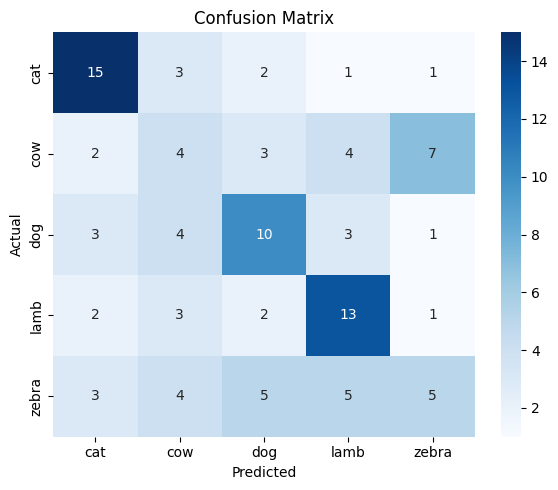

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [14]:
import random
for i in random.sample(range(len(X_test)), 5):
    print(f"Sample {i}: Predicted: {classes[y_pred[i]]} | Actual: {classes[y_test[i]]}")

Sample 10: Predicted: lamb | Actual: lamb
Sample 87: Predicted: cow | Actual: cat
Sample 5: Predicted: zebra | Actual: cow
Sample 102: Predicted: lamb | Actual: lamb
Sample 12: Predicted: cat | Actual: cat
